# Attempt 1 (Quantization here, training in quantize_2)

In [37]:
# Quantization code from Song Han's TinyML class
import torch

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

In [38]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    get quantization scale for single tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max()
    fp_min = fp_tensor.min()

    # scale
    scale = (fp_max - fp_min) / (quantized_max - quantized_min)
    # zero_point
    zero_point = ((quantized_min - fp_min / scale))

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # convert from float to int using round()
        zero_point = round(zero_point)
    return scale, int(zero_point)

In [39]:
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=np.int8) -> np.array:
    """
    linear quantization for single fp_tensor
      from
        r = fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        q = quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [np.array] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [float] scaling factor
    :param zero_point: [int] the desired centroid of tensor values
    :return:
        [np.array] quantized tensor whose values are integers
    """
    # assert(fp_tensor is np.array)
    assert(isinstance(scale, float))
    assert(isinstance(zero_point, int))

    # scale the fp_tensor
    scaled_tensor = fp_tensor/scale
    # round the floating value to integer value
    rounded_tensor = (np.round(scaled_tensor)) #.to(torch.int8)

    # print(rounded_tensor.dtype)

    # shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor + zero_point

    # clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clip(quantized_min, quantized_max)
    quantized_tensor = quantized_tensor.astype(np.int8)
    return quantized_tensor

In [40]:
def linear_quantize_feature(fp_tensor, bitwidth):
    """
    linear quantization for feature tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [float] scale tensor
        [int] zero point
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point

In [47]:
checkpoint = torch.load("./NN/mnist_01_100_2.pt")
# checkpoint = torch.load("./NN/MNIST_12_layers.pt")

weights_biases = {}

for name, param in checkpoint.items():
    weights_biases[name] = param.cpu().numpy()  # Convert to numpy array and store

int8_quant = {}

for key in weights_biases:
    print(key)
    int8_quant[key] = linear_quantize_feature(weights_biases[key], 3)[0]
    # print(int8_quant[key].shape)
    # print(weights_biases[key].shape)

fc1.weight
fc1.bias


In [48]:
def run_nn(input):
    layer1 = np.dot(weights_biases["fc1.weight"], input) + weights_biases["fc1.bias"]
    # layer2 = np.dot(weights_biases["fc2.weight"], layer1) + weights_biases["fc2.bias"]
    # layer3 = np.dot(weights_biases["fc3.weight"], layer2) + weights_biases["fc3.bias"]
    return np.argmax(layer1)

def run_quantized_nn(input):
    layer1 = np.dot(int8_quant["fc1.weight"], input) + int8_quant["fc1.bias"]
    # layer2 = np.dot(int8_quant["fc2.weight"], layer1) + int8_quant["fc2.bias"]
    # layer3 = np.dot(int8_quant["fc3.weight"], layer2) + int8_quant["fc3.bias"]
    return np.argmax(layer1)

In [32]:
def convert_img_to_numpy_arr(fp):
  img = Image.open(fp)

  # Convert the image to grayscale
  img = img.convert("L")

  pixel_values = np.array(img)

  img_flattened = pixel_values.reshape(-1)

  img_flattened = [0 if x > 127 else 1 for x in img_flattened]

  return np.array(img_flattened)

In [33]:
def display_image(img_flat):
    for i in range(1):
        flattened_tensor = img_flat  # Replace with your actual data

        # Reshape to 28 x 28
        image_tensor = flattened_tensor.reshape(28, 28)  # or .reshape(28, 28)

        # Plot the image
        plt.imshow(image_tensor, cmap="gray")
        plt.colorbar()  # Optional: to show the color scale
        plt.show()

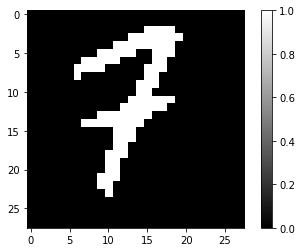

2


2

In [34]:
fp = "./images/7.png"

flat_image = convert_img_to_numpy_arr(fp)
display_image(flat_image)
print(run_nn(flat_image))
run_quantized_nn(flat_image)

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()


if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 64}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


transform=transforms.Compose([
        transforms.Resize((10, 10)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: torch.where(x > 0.7, torch.tensor(1.0), torch.tensor(0.0))),
        transforms.Lambda(lambda x: x.view(-1))
        ])

def filter_0_and_1(dataset):
    indices = [i for i, target in enumerate(dataset.targets) if target == 0 or target == 1]
    dataset.targets = dataset.targets[indices]
    dataset.data = dataset.data[indices]
    return dataset

test_dataset = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
test_dataset = filter_0_and_1(test_dataset)

dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
dataset2 = filter_0_and_1(dataset2)

# Create the DataLoader
train_loader = torch.utils.data.DataLoader(test_dataset)
test_loader = torch.utils.data.DataLoader(dataset2)

In [50]:
total = 900
correct = 0

for i in range(900):
    img = test_dataset[i][0]
    #display_image(img)
    label = test_dataset[i][1]
    # print(run_nn(img))
    # print(run_quantized_nn(img))
    if run_quantized_nn(img) == label:
        correct += 1

print(correct/total)

0.9888888888888889


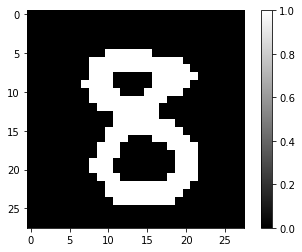

Quantized NN answer:  8


In [340]:
img = test_dataset[i][0]
display_image(img)
print("Quantized NN answer: ", run_quantized_nn(img))

In [ ]:
# Attempt 2

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return output